In [1]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [2]:
import os
import pandas
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
from helper_funcs import *

In [3]:
df = pd.read_csv('../Data/ABIDE_df2.csv')
df = df.iloc[~pd.isna(df['bids_folder']).values]
df = df.sort_values(by='bids_folder')
patients = df['DX_GROUP'].values==1
print(len(df))
df.head(3)

1048


,participant_id,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,...,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI,bids_folder,site
460,50642,1,1.0,33.0,1,R,NaN,103.0,98.0,107.0,...,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050642,1
464,50646,1,1.0,21.0,1,R,NaN,108.0,100.0,115.0,...,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050646,1
465,50647,1,1.0,27.0,1,R,NaN,104.0,97.0,109.0,...,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050647,1


In [4]:
avail = [file for file in os.listdir(os.path.join('../Assets')) if file.startswith('cmat_latents_')]
avail.sort()
avail

['cmat_latents_CVAE_2021-10-27 11:41:44.052073.pickle',
 'cmat_latents_CVAE_2021-10-28 05:12:17.623449.pickle',
 'cmat_latents_CVAE_2021-10-28 12:51:07.008750.pickle']

In [5]:
analysis_name = 'CVAE_2021-10-27 11:41:44.052073'
#analysis_name = 'CVAE_2021-10-28 05:12:17.623449'
#analysis_name= 'CVAE_2021-10-28 12:51:07.008750'
latent_fn = os.path.join('../Assets',f'cmat_latents_{analysis_name}.pickle')
latent_data = pickle.load(open(latent_fn,'rb'))
data = latent_data
print(analysis_name)

CVAE_2021-10-27 11:41:44.052073


In [6]:
keys = list(latent_data.keys())
for key in keys:
    #print(f'{key} {latent_data[key].shape}')
    print(key+f'{latent_data[key].shape}'.rjust(30-len(key)))

Z_mu                (1048, 16)
Z_sigma             (1048, 16)
Z                   (1048, 16)
S_mu                (1048, 16)
S_sigma             (1048, 16)
S                   (1048, 16)
z_samples      (100, 1048, 16)
s_samples      (100, 1048, 16)
z_embedding           (514, 2)
s_embedding           (514, 2)
predicted       (1048, 51, 51)
predicted_bg    (1048, 51, 51)
cData           (1048, 51, 51)


In [7]:
patients = df['DX_GROUP'].values==1

Text(0.5, 1.0, 'S_ratio')

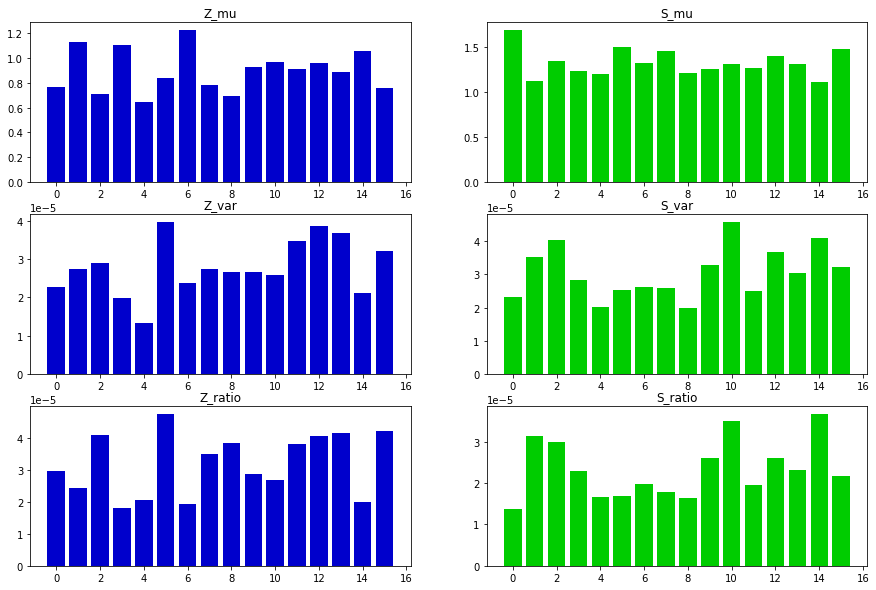

In [8]:
xs = np.arange(16)

Z_mu = latent_data['Z_mu'][patients,:].std(axis=0)
S_mu = latent_data['S_mu'][patients,:].std(axis=0)

Z_var = np.e**latent_data['Z_sigma'][patients,:].mean(axis=0)
S_var = np.e**latent_data['S_sigma'][patients,:].mean(axis=0)

Z_rat = Z_var / Z_mu
S_rat = S_var / S_mu

plt.subplots(3,2,figsize=(15,10))
plt.subplot(3,2,1)
plt.bar(np.arange(Z_mu.shape[0]),Z_mu,facecolor=np.array([0,0,1])*.8);plt.title('Z_mu')

plt.subplot(3,2,2)
plt.bar(np.arange(S_mu.shape[0]),S_mu,facecolor=np.array([0,1,0])*.8);plt.title('S_mu')

plt.subplot(3,2,3)
plt.bar(np.arange(Z_mu.shape[0]),Z_var,facecolor=np.array([0,0,1])*.8);plt.title('Z_var')

plt.subplot(3,2,4)
plt.bar(np.arange(S_mu.shape[0]),S_var,facecolor=np.array([0,1,0])*.8);plt.title('S_var')

plt.subplot(3,2,5)
plt.bar(np.arange(Z_mu.shape[0]),Z_rat,facecolor=np.array([0,0,1])*.8);plt.title('Z_ratio')

plt.subplot(3,2,6)
plt.bar(np.arange(S_mu.shape[0]),S_rat,facecolor=np.array([0,1,0])*.8);plt.title('S_ratio')

In [9]:
import umap
reducer = umap.UMAP(n_components=2)

umap_bg_all = reducer.fit_transform(data['Z'])
umap_sl_all = reducer.fit_transform(data['S'])

umap_bg_asd = reducer.fit_transform(data['Z'][patients,:])
umap_sl_asd = reducer.fit_transform(data['S'][patients,:])

Text(0.5, 1.0, 'SL')

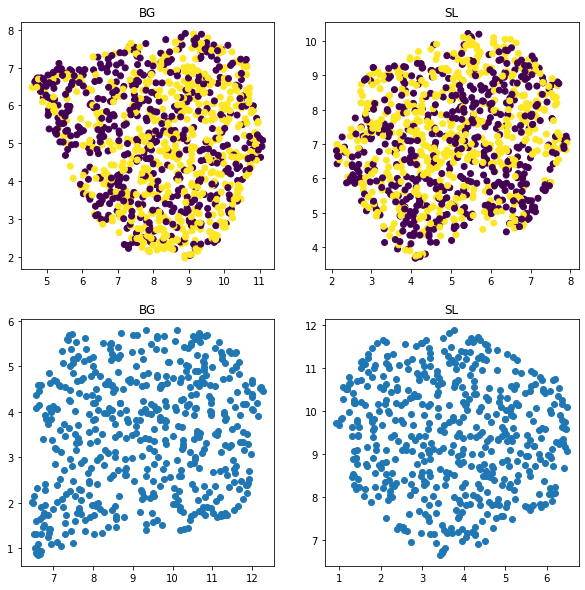

In [10]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(umap_bg_all[:,0],umap_bg_all[:,1],c=df['DX_GROUP'].values);plt.title('BG')
plt.subplot(2,2,2)
plt.scatter(umap_sl_all[:,0],umap_sl_all[:,1],c=df['DX_GROUP'].values);plt.title('SL')

plt.subplot(2,2,3)
plt.scatter(umap_bg_asd[:,0],umap_bg_asd[:,1]);plt.title('BG')
plt.subplot(2,2,4)
plt.scatter(umap_sl_asd[:,0],umap_sl_asd[:,1]);plt.title('SL')

In [11]:
rdm_z = make_RDM(data['Z'][patients,:])
rdm_s = make_RDM(data['S'][patients,:])

rdm_data = np.array([get_triu(data['cData'][i,:,:]) for i in range(1048)])
rdm_data = np.corrcoef(rdm_data)

SL-BG RDM corr 0.4026


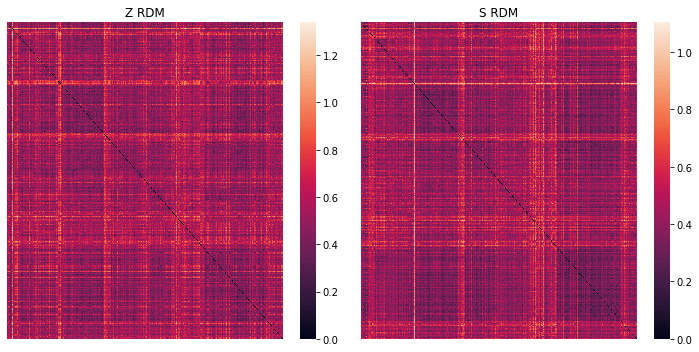

In [12]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.heatmap(rdm_z,xticklabels=[],yticklabels=[]);plt.title('Z RDM')
plt.subplot(1,2,2)
sns.heatmap(rdm_s,xticklabels=[],yticklabels=[]);plt.title('S RDM')
plt.tight_layout()
print(f'SL-BG RDM corr {np.corrcoef(get_triu(rdm_s),get_triu(rdm_z))[0,1]:.4f}')

In [13]:
df.columns

Index(['participant_id', 'DX_GROUP', 'DSM_IV_TR', 'AGE_AT_SCAN', 'SEX',
       'HANDEDNESS_CATEGORY', 'HANDEDNESS_SCORES', 'FIQ', 'VIQ', 'PIQ',
       'FIQ_TEST_TYPE', 'VIQ_TEST_TYPE', 'PIQ_TEST_TYPE',
       'ADI_R_SOCIAL_TOTAL_A', 'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C',
       'ADI_R_ONSET_TOTAL_D', 'ADI_R_RSRCH_RELIABLE', 'ADOS_MODULE',
       'ADOS_TOTAL', 'ADOS_COMM', 'ADOS_SOCIAL', 'ADOS_STEREO_BEHAV',
       'ADOS_RSRCH_RELIABLE', 'ADOS_GOTHAM_SOCAFFECT', 'ADOS_GOTHAM_RRB',
       'ADOS_GOTHAM_TOTAL', 'ADOS_GOTHAM_SEVERITY', 'SRS_VERSION',
       'SRS_RAW_TOTAL', 'SRS_AWARENESS', 'SRS_COGNITION', 'SRS_COMMUNICATION',
       'SRS_MOTIVATION', 'SRS_MANNERISMS', 'SCQ_TOTAL', 'AQ_TOTAL',
       'COMORBIDITY', 'CURRENT_MED_STATUS', 'MEDICATION_NAME',
       'OFF_STIMULANTS_AT_SCAN', 'VINELAND_RECEPTIVE_V_SCALED',
       'VINELAND_EXPRESSIVE_V_SCALED', 'VINELAND_WRITTEN_V_SCALED',
       'VINELAND_COMMUNICATION_STANDARD', 'VINELAND_PERSONAL_V_SCALED',
       'VINELAND_DOMESTIC_V_S

In [14]:
keys = ['ADOS_TOTAL', 'ADOS_COMM', 'ADOS_SOCIAL', 'ADOS_STEREO_BEHAV',]
mat = df[keys].values
v = np.isnan(mat).sum(axis=1)==0
mat = mat[v,:]
pc = PCA(n_components=1).fit_transform(mat)
df['ADOS_PCA'] = np.nan
df['ADOS_PCA'].values[v] = pc.reshape(-1)

keys = ['ADI_R_SOCIAL_TOTAL_A', 'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C',
       'ADI_R_ONSET_TOTAL_D']
mat = df[keys].values
v = np.isnan(mat).sum(axis=1)==0
mat = mat[v,:]
pc = PCA(n_components=1).fit_transform(mat)
df['ADI_PCA'] = np.nan
df['ADI_PCA'].values[v] = pc.reshape(-1)

keys = ['VINELAND_EXPRESSIVE_V_SCALED', 'VINELAND_WRITTEN_V_SCALED',
       'VINELAND_COMMUNICATION_STANDARD', 'VINELAND_PERSONAL_V_SCALED',
       'VINELAND_DOMESTIC_V_SCALED', 'VINELAND_COMMUNITY_V_SCALED',
       'VINELAND_DAILYLVNG_STANDARD', 'VINELAND_INTERPERSONAL_V_SCALED',
       'VINELAND_PLAY_V_SCALED', 'VINELAND_COPING_V_SCALED',
       'VINELAND_SOCIAL_STANDARD', 'VINELAND_SUM_SCORES',
       'VINELAND_ABC_STANDARD', 'VINELAND_INFORMANT']
mat = df[keys].values
v = np.isnan(mat).sum(axis=1)==0
mat = mat[v,:]
pc = PCA(n_components=1).fit_transform(mat)
df['VINELAND_PCA'] = np.nan
df['VINELAND_PCA'].values[v] = pc.reshape(-1)

In [15]:
n = latent_data['cData'].shape[0]
latent_data['cTriu'] = np.array([get_triu(latent_data['cData'][i,:,:]) for i in range(n)])

In [16]:
from operator import itemgetter
def slice_df(key,init_slice=None):

    nsubs = latent_data['S'].shape[0]
    
    if type(init_slice)==type(None):
        patients = np.repeat(True,nsubs)
    elif type(init_slice)==type(1):
        patients = df['DX_GROUP'].values==init_slice
    elif type(init_slice)==type(np.array(0)) and len(init_slice)==len(df):
        patients = init_slice
    else:
        print(init_slice)
        print(type(init_slice))
        raise BaseException('Weird slice wtf')
    
    X_s = latent_data['S'][patients,:]
    X_z = latent_data['Z'][patients,:]
    cdata = latent_data['cTriu'][patients,:]
    
    Y = df[key].values[patients]
    v = ~np.isnan(Y)#[:,0]
    v = v.reshape(-1)

    X_s = X_s[v,:]
    X_z = X_z[v,:]
    Y = Y[v]
    cdata = cdata[v,:]
    cdata = PCA(n_components=16).fit_transform(cdata)
    #print(X.shape)
    #print(Y.shape)
    
    slice_ = dict()
    slice_['X_s'] = X_s
    slice_['X_z'] = X_z
    slice_['triu'] = cdata
    slice_['Y'] = Y
    
    #[print(slice_[key].shape) for key in list(slice_.keys())];
    
    return slice_

In [17]:
def y_yh_scatter(Y,y_hats):
    plt.scatter(Y,y_hats)

    r = np.corrcoef(Y,y_hats)[0,1]
    b,c = np.polyfit(Y,y_hats,1)
    plt.plot(Y,(Y*b)+c,'r-')
    r2 = r2_score(Y,y_hats)
    
    #plt.title(f'r = {r:.2f},b = {b:.2f}')
    plt.title(f'r^2 = {r2.round(3)}')
    
    plt.xlim(min(Y)-.1,max(Y)+.1)
    plt.ylim(min(Y)-.1,max(Y)+.1)

In [257]:
def crossval_resampled(clf,X,Y,cv=5,resample=True):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=cv) #Set up kfold
    y_pred = np.repeat(np.nan,Y.shape) # initiate array 
    
    for train_index, test_index in kf.split(X,Y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        #print(f'train {y_test.shape[0]} / test {y_test.shape[0]}')
        
        if resample:
            X_train, y_train = oversampler.fit_resample(X_train, y_train)

        y_pred[test_index] = clf.fit(X_train,y_train).predict(X_test)
        #y_pred[test_index] = clf.fit(X_test,y_test).predict(X_test)
        
    # ASSERTS     
    assert np.isnan(y_pred).sum()==0,'nans in prediction'
    
    if resample:
        assert len(np.unique(np.unique(y_train,return_counts=True)[1]))==1,'unbalanced train!'
    
    return y_pred

In [258]:
from imblearn.over_sampling import SMOTE,RandomOverSampler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score,r2_score

# MODELS
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.svm import SVR,SVC
from sklearn.linear_model import LogisticRegression,LinearRegression,Ridge,ElasticNet,Lasso,SGDRegressor,SGDClassifier
import xgboost as xgb

# sm = SMOTE(random_state=42)
# sm = RandomOverSampler(random_state=42)

#oversampler = SMOTE(random_state=42)
oversampler = RandomOverSampler(random_state=42)

In [259]:
#clf = xgb.XGBClassifier(eval_metric='mlogloss',use_label_encoder=False)
clf = xgb.XGBRFClassifier(eval_metric='mlogloss',use_label_encoder=False)
reg = xgb.XGBRFRegressor()
#reg = xgb.XGBRegressor()

# clf = DecisionTreeClassifier()
# reg = DecisionTreeRegressor()

clf = LogisticRegression(penalty='l2',max_iter=500,C=1)
reg = LinearRegression()

# clf = SVC(C=1.0,kernel='rbf',degree=3,gamma='scale',coef0=0.0,shrinking=True,probability=False,tol=0.001,cache_size=200,class_weight=None,verbose=False,max_iter=-1,decision_function_shape='ovr',break_ties=False,random_state=None)
# reg = SVR(kernel='rbf',degree=3,gamma='scale',coef0=0.0,tol=0.001,C=1.0,epsilon=0.1,shrinking=True,cache_size=200,verbose=False,max_iter=-1)

In [260]:
def norm(vec):
    return (vec-vec.min())/(vec.max()-vec.min())

In [261]:
nCV = 100

Text(0.5, 0.98, 'AGE ASD')

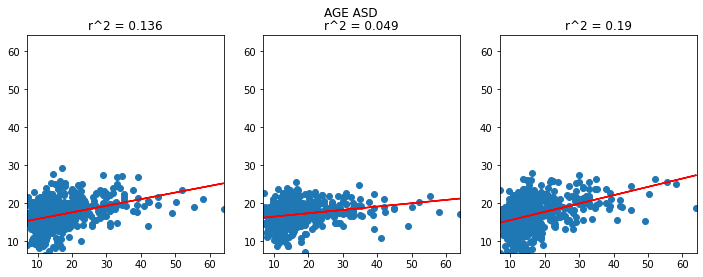

In [262]:
slice_ = slice_df('AGE_AT_SCAN',init_slice=1)
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

yz_pred = crossval_resampled(reg, X_z, Y, cv=nCV,resample=False)
ys_pred = crossval_resampled(reg, X_s, Y, cv=nCV,resample=False)
yc_pred = crossval_resampled(reg, X_c, Y, cv=nCV,resample=False)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1);y_yh_scatter(Y,yz_pred)
plt.subplot(1,3,2);y_yh_scatter(Y,ys_pred)
plt.subplot(1,3,3);y_yh_scatter(Y,yc_pred)
plt.suptitle('AGE ASD')

Text(0.5, 0.98, 'AGE TD')

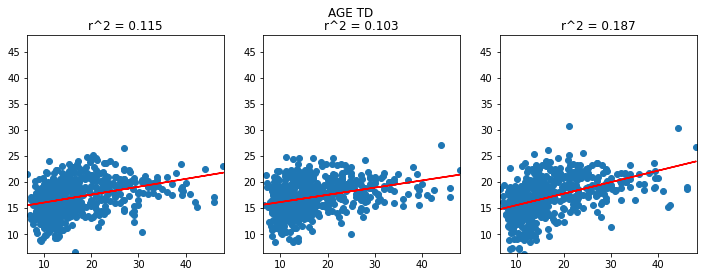

In [263]:
slice_ = slice_df('AGE_AT_SCAN',init_slice=2)
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

yz_pred = crossval_resampled(reg, X_z, Y, cv=nCV,resample=False)
ys_pred = crossval_resampled(reg, X_s, Y, cv=nCV,resample=False)
yc_pred = crossval_resampled(reg, X_c, Y, cv=nCV,resample=False)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1);y_yh_scatter(Y,yz_pred)
plt.subplot(1,3,2);y_yh_scatter(Y,ys_pred)
plt.subplot(1,3,3);y_yh_scatter(Y,yc_pred)
plt.suptitle('AGE TD')

In [264]:
def tabulate(Y):
    print(pd.DataFrame(Y).value_counts())

In [265]:
from sklearn.cluster import KMeans

In [266]:
def plot_clfs(pred_arrs,Y,key=None):
    #pred_arrs = [y_pred_z,y_pred_s,y_pred_c]
    ys = [(pred_arr==Y).mean() for pred_arr in pred_arrs]
    xs = np.arange(len(ys))
    plt.bar(xs,ys)
    xlim = plt.xlim()
    plt.plot(xlim,[1/len(np.unique(Y)),1/len(np.unique(Y))],'k--');
    xlbls = ['BG','SL','C'];
    plt.xticks(xs,labels=xlbls);
    
    if type(key)!=type(None):
        plt.title(key)

In [267]:
slice_ = slice_df('AGE_AT_SCAN')
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)
Y_vals = Y
Y = KMeans(n_clusters=5).fit_predict(Y[:,np.newaxis])

In [268]:
y_pred_z = crossval_resampled(clf, X_z, Y, cv=nCV)
y_pred_s = crossval_resampled(clf, X_s, Y, cv=nCV)
y_pred_c = crossval_resampled(clf, X_c, Y, cv=nCV)

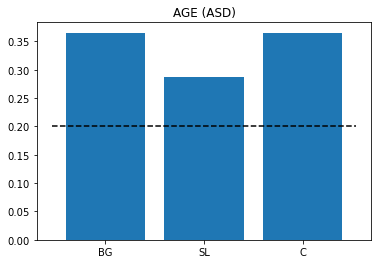

In [269]:
plot_clfs([y_pred_z,y_pred_s,y_pred_c],Y,key='AGE (ASD)')

In [270]:
slice_ = slice_df('AGE_AT_SCAN',init_slice=2)
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)
Y = KMeans(n_clusters=5).fit_predict(Y[:,np.newaxis])

In [271]:
y_pred_z = crossval_resampled(clf, X_z, Y, cv=nCV)
y_pred_s = crossval_resampled(clf, X_s, Y, cv=nCV)
y_pred_c = crossval_resampled(clf, X_c, Y, cv=nCV)

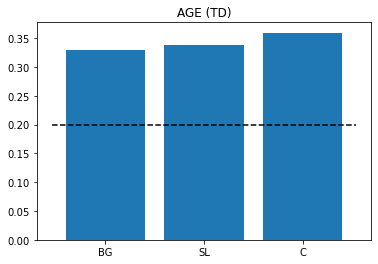

In [272]:
plot_clfs([y_pred_z,y_pred_s,y_pred_c],Y,key='AGE (TD)')

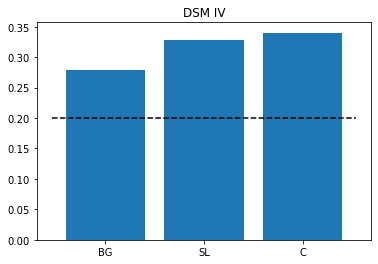

In [273]:
slice_ = slice_df('DSM_IV_TR')
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

y_pred_z = crossval_resampled(clf, X_z, Y, cv=5)
y_pred_s = crossval_resampled(clf, X_s, Y, cv=5)
y_pred_c = crossval_resampled(clf, X_c, Y, cv=5)

plot_clfs([y_pred_z,y_pred_s,y_pred_c],Y,key='DSM IV')

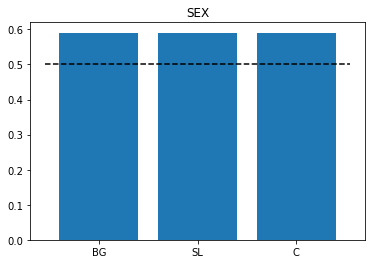

In [274]:
slice_ = slice_df('SEX')
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

y_pred_z = crossval_resampled(clf, X_z, Y, cv=nCV)
y_pred_s = crossval_resampled(clf, X_s, Y, cv=nCV)
y_pred_c = crossval_resampled(clf, X_c, Y, cv=nCV)

plot_clfs([y_pred_z,y_pred_s,y_pred_c],Y,key='SEX')

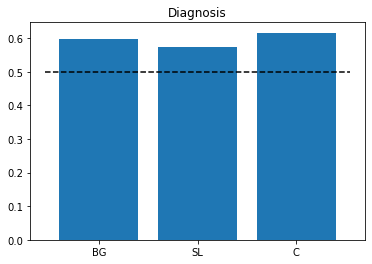

In [275]:
slice_ = slice_df('DX_GROUP',None)
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)
#Y = Y-1

y_pred_z = crossval_resampled(clf, X_z, Y, cv=nCV)
y_pred_s = crossval_resampled(clf, X_s, Y, cv=nCV)
y_pred_c = crossval_resampled(clf, X_c, Y, cv=nCV)

plot_clfs([y_pred_z,y_pred_s,y_pred_c],Y,key='Diagnosis')

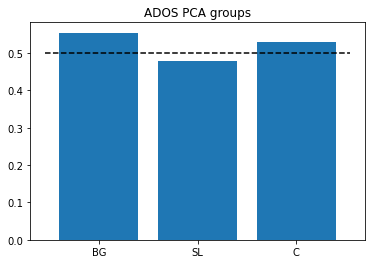

In [276]:
slice_ = slice_df('ADOS_PCA')
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)
Y = KMeans(n_clusters=2).fit_predict(Y[:,np.newaxis])

y_pred_z = crossval_resampled(clf, X_z, Y, cv=nCV)
y_pred_s = crossval_resampled(clf, X_s, Y, cv=nCV)
y_pred_c = crossval_resampled(clf, X_c, Y, cv=nCV)

plot_clfs([y_pred_z,y_pred_s,y_pred_c],Y,key='ADOS PCA groups')

Text(0.5, 0.98, 'ADOS_Total')

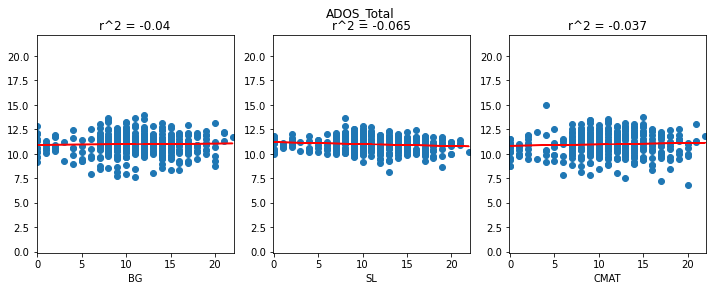

In [277]:
slice_ = slice_df('ADOS_TOTAL')
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

yz_pred = crossval_resampled(reg, X_z, Y, cv=nCV,resample=False)
ys_pred = crossval_resampled(reg, X_s, Y, cv=nCV,resample=False)
yc_pred = crossval_resampled(reg, X_c, Y, cv=nCV,resample=False)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1);y_yh_scatter(Y,yz_pred);plt.xlabel('BG')
plt.subplot(1,3,2);y_yh_scatter(Y,ys_pred);plt.xlabel('SL')
plt.subplot(1,3,3);y_yh_scatter(Y,yc_pred);plt.xlabel('CMAT')

plt.suptitle('ADOS_Total',fontsize=12)

Text(0.5, 0.98, 'ADOS_Total')

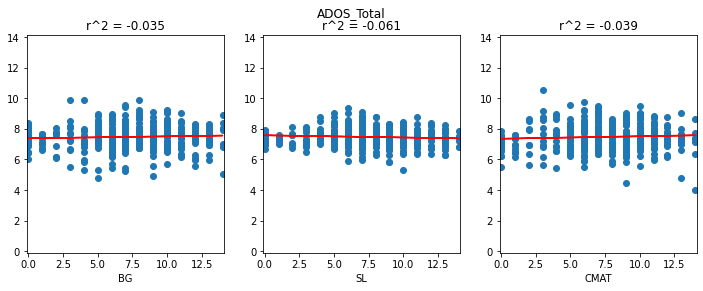

In [278]:
slice_ = slice_df('ADOS_SOCIAL')
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

yz_pred = crossval_resampled(reg, X_z, Y, cv=nCV,resample=False)
ys_pred = crossval_resampled(reg, X_s, Y, cv=nCV,resample=False)
yc_pred = crossval_resampled(reg, X_c, Y, cv=nCV,resample=False)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1);y_yh_scatter(Y,yz_pred);plt.xlabel('BG')
plt.subplot(1,3,2);y_yh_scatter(Y,ys_pred);plt.xlabel('SL')
plt.subplot(1,3,3);y_yh_scatter(Y,yc_pred);plt.xlabel('CMAT')

plt.suptitle('ADOS_SOCIAL',fontsize=12)

Text(0.5, 0.98, 'ADOS_Total')

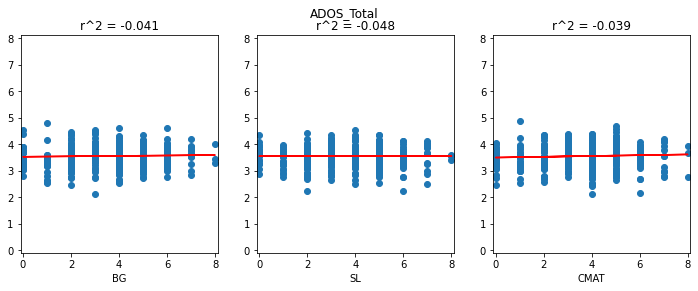

In [279]:
slice_ = slice_df('ADOS_COMM')
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

yz_pred = crossval_resampled(reg, X_z, Y, cv=nCV,resample=False)
ys_pred = crossval_resampled(reg, X_s, Y, cv=nCV,resample=False)
yc_pred = crossval_resampled(reg, X_c, Y, cv=nCV,resample=False)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1);y_yh_scatter(Y,yz_pred);plt.xlabel('BG')
plt.subplot(1,3,2);y_yh_scatter(Y,ys_pred);plt.xlabel('SL')
plt.subplot(1,3,3);y_yh_scatter(Y,yc_pred);plt.xlabel('CMAT')

plt.suptitle('ADOS_COMM',fontsize=12)

Text(0.5, 0.98, 'ADOS_PCA')

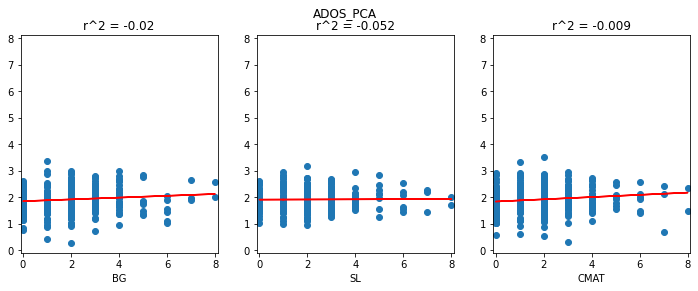

In [280]:
slice_ = slice_df('ADOS_STEREO_BEHAV')
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

yz_pred = crossval_resampled(reg, X_z, Y, cv=nCV,resample=False)
ys_pred = crossval_resampled(reg, X_s, Y, cv=nCV,resample=False)
yc_pred = crossval_resampled(reg, X_c, Y, cv=nCV,resample=False)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1);y_yh_scatter(Y,yz_pred);plt.xlabel('BG')
plt.subplot(1,3,2);y_yh_scatter(Y,ys_pred);plt.xlabel('SL')
plt.subplot(1,3,3);y_yh_scatter(Y,yc_pred);plt.xlabel('CMAT')

plt.suptitle('ADOS_STEREO_BEHAV',fontsize=12)

Text(0.5, 0.98, 'ADOS_PCA')

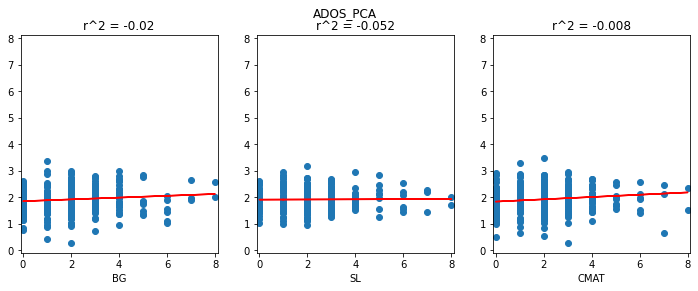

In [281]:
slice_ = slice_df('ADOS_STEREO_BEHAV')
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

yz_pred = crossval_resampled(reg, X_z, Y, cv=nCV,resample=False)
ys_pred = crossval_resampled(reg, X_s, Y, cv=nCV,resample=False)
yc_pred = crossval_resampled(reg, X_c, Y, cv=nCV,resample=False)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1);y_yh_scatter(Y,yz_pred);plt.xlabel('BG')
plt.subplot(1,3,2);y_yh_scatter(Y,ys_pred);plt.xlabel('SL')
plt.subplot(1,3,3);y_yh_scatter(Y,yc_pred);plt.xlabel('CMAT')

plt.suptitle('ADOS_STEREO_BEHAV',fontsize=12)

Text(0.5, 0.98, 'SRS_RAW_TOTAL')

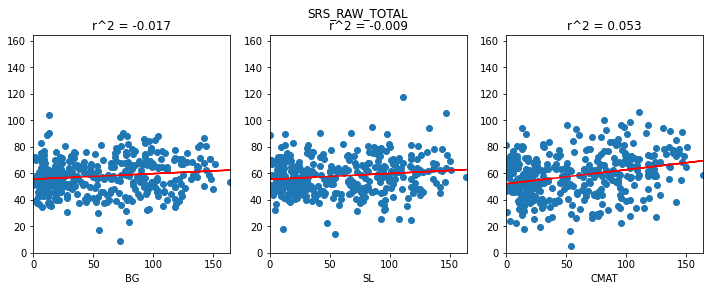

In [282]:
slice_ = slice_df('SRS_RAW_TOTAL')
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

yz_pred = crossval_resampled(reg, X_z, Y, cv=nCV,resample=False)
ys_pred = crossval_resampled(reg, X_s, Y, cv=nCV,resample=False)
yc_pred = crossval_resampled(reg, X_c, Y, cv=nCV,resample=False)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1);y_yh_scatter(Y,yz_pred);plt.xlabel('BG')
plt.subplot(1,3,2);y_yh_scatter(Y,ys_pred);plt.xlabel('SL')
plt.subplot(1,3,3);y_yh_scatter(Y,yc_pred);plt.xlabel('CMAT')

plt.suptitle('SRS_RAW_TOTAL',fontsize=12)

Text(0.5, 0.98, 'FIQ')

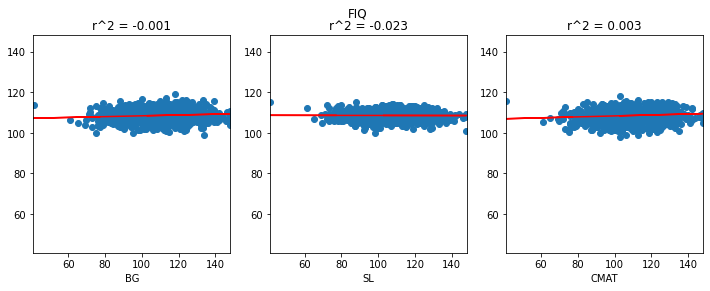

In [283]:
slice_ = slice_df('FIQ')
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

yz_pred = crossval_resampled(reg, X_z, Y, cv=nCV,resample=False)
ys_pred = crossval_resampled(reg, X_s, Y, cv=nCV,resample=False)
yc_pred = crossval_resampled(reg, X_c, Y, cv=nCV,resample=False)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1);y_yh_scatter(Y,yz_pred);plt.xlabel('BG')
plt.subplot(1,3,2);y_yh_scatter(Y,ys_pred);plt.xlabel('SL')
plt.subplot(1,3,3);y_yh_scatter(Y,yc_pred);plt.xlabel('CMAT')

plt.suptitle('FIQ',fontsize=12)

Text(0.5, 0.98, 'FIQ')

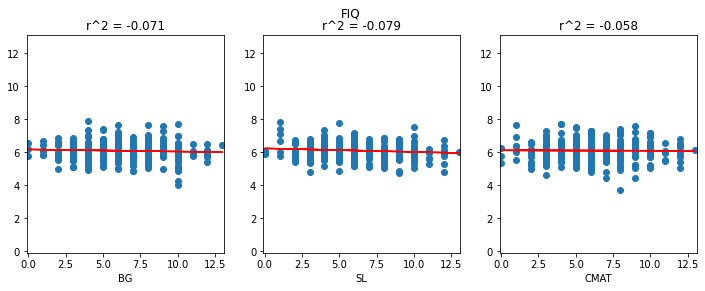

In [284]:
slice_ = slice_df('ADI_RRB_TOTAL_C')
X_z,X_s,X_c,Y = itemgetter('X_z','X_s','triu','Y')(slice_)

yz_pred = crossval_resampled(reg, X_z, Y, cv=nCV,resample=False)
ys_pred = crossval_resampled(reg, X_s, Y, cv=nCV,resample=False)
yc_pred = crossval_resampled(reg, X_c, Y, cv=nCV,resample=False)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1);y_yh_scatter(Y,yz_pred);plt.xlabel('BG')
plt.subplot(1,3,2);y_yh_scatter(Y,ys_pred);plt.xlabel('SL')
plt.subplot(1,3,3);y_yh_scatter(Y,yc_pred);plt.xlabel('CMAT')

plt.suptitle('ADI_RRB_TOTAL_C',fontsize=12)

In [285]:
df.columns

Index(['participant_id', 'DX_GROUP', 'DSM_IV_TR', 'AGE_AT_SCAN', 'SEX',
       'HANDEDNESS_CATEGORY', 'HANDEDNESS_SCORES', 'FIQ', 'VIQ', 'PIQ',
       'FIQ_TEST_TYPE', 'VIQ_TEST_TYPE', 'PIQ_TEST_TYPE',
       'ADI_R_SOCIAL_TOTAL_A', 'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C',
       'ADI_R_ONSET_TOTAL_D', 'ADI_R_RSRCH_RELIABLE', 'ADOS_MODULE',
       'ADOS_TOTAL', 'ADOS_COMM', 'ADOS_SOCIAL', 'ADOS_STEREO_BEHAV',
       'ADOS_RSRCH_RELIABLE', 'ADOS_GOTHAM_SOCAFFECT', 'ADOS_GOTHAM_RRB',
       'ADOS_GOTHAM_TOTAL', 'ADOS_GOTHAM_SEVERITY', 'SRS_VERSION',
       'SRS_RAW_TOTAL', 'SRS_AWARENESS', 'SRS_COGNITION', 'SRS_COMMUNICATION',
       'SRS_MOTIVATION', 'SRS_MANNERISMS', 'SCQ_TOTAL', 'AQ_TOTAL',
       'COMORBIDITY', 'CURRENT_MED_STATUS', 'MEDICATION_NAME',
       'OFF_STIMULANTS_AT_SCAN', 'VINELAND_RECEPTIVE_V_SCALED',
       'VINELAND_EXPRESSIVE_V_SCALED', 'VINELAND_WRITTEN_V_SCALED',
       'VINELAND_COMMUNICATION_STANDARD', 'VINELAND_PERSONAL_V_SCALED',
       'VINELAND_DOMESTIC_V_S